In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_rows", None)  # 행 전부 보기
pd.set_option("display.max_columns", None)  # 열 전부 보기
pd.set_option("display.width", 1000)  # 가로 폭 조절

In [24]:
# 📌 Jupyter에서 한글 깨짐 방지 + 스타일 설정
%matplotlib inline
import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

sns.set(style="whitegrid")

In [15]:
file_path = os.path.join("../../dataset", "phishing_data.csv")
df = pd.read_csv(file_path)

In [16]:
# --- 2. 전처리 ---
df["text"] = df["text"].fillna("").astype(str)

In [17]:
# --- 3. file_name 기준으로 메시지 합치기 및 문자 수 계산 ---
msg_lengths = (
    df.groupby("file_name")["text"]
    .apply(lambda x: len("".join(x)))
    .reset_index(name="char_count")
)

In [18]:
# --- 4. phishing_type 병합 ---
msg_lengths = msg_lengths.merge(
    df[["file_name", "phishing_type"]].drop_duplicates(),
    on="file_name",
    how="left")

In [19]:
# --- 5. 문자 수 기준 길이 구간 나누기 ---
bins = [0, 500, 1000, float("inf")]
labels = ["0-500", "501-1000", "1000+"]
msg_lengths["length_group"] = pd.cut(
    msg_lengths["char_count"], bins=bins, labels=labels
)

In [20]:
# --- 6. 문자 수 describe 통계 출력 ---
print("📊 문자 수 describe 통계:")
print(msg_lengths["char_count"].describe())

📊 문자 수 describe 통계:
count     2049.000000
mean       784.271840
std       1894.832599
min         20.000000
25%        118.000000
50%        186.000000
75%        498.000000
max      23615.000000
Name: char_count, dtype: float64


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_143012\3461218162.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=msg_lengths, x="length_group", palette="pastel")


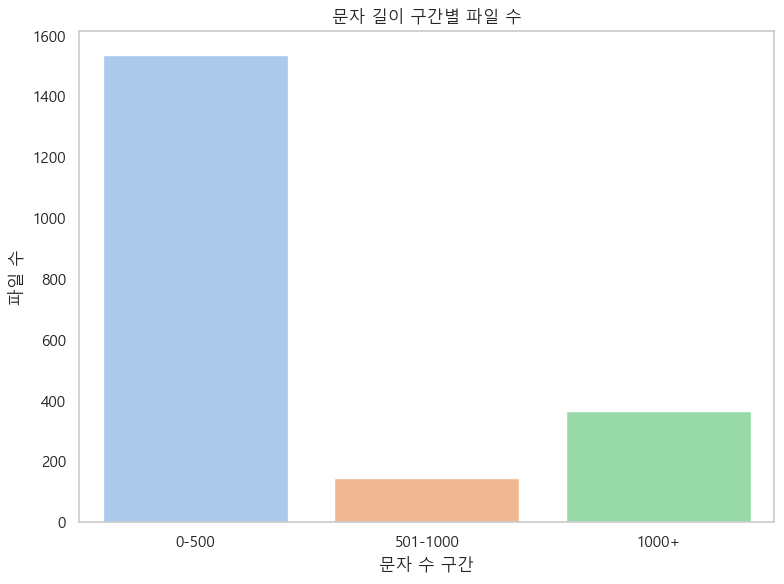

In [ ]:
# --- ✅ 시각화 시작 ---
%matplotlib inline
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

# 📈 1. 문자 길이 구간별 분포
plt.figure(figsize=(8, 6))
sns.countplot(data=msg_lengths, x="length_group", palette="pastel")
plt.title("문자 길이 구간별 파일 수")
plt.xlabel("문자 수 구간")
plt.ylabel("파일 수")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

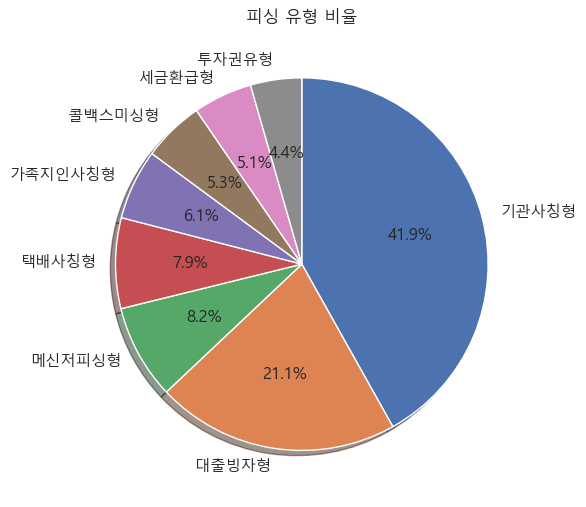

In [27]:
# 🥧 2. 피싱 유형 분포 (원형 차트)
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

plt.figure(figsize=(6, 6))
msg_lengths["phishing_type"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=90, counterclock=False, shadow=True
)
plt.title("피싱 유형 비율")
plt.ylabel("")
plt.tight_layout()
plt.show()

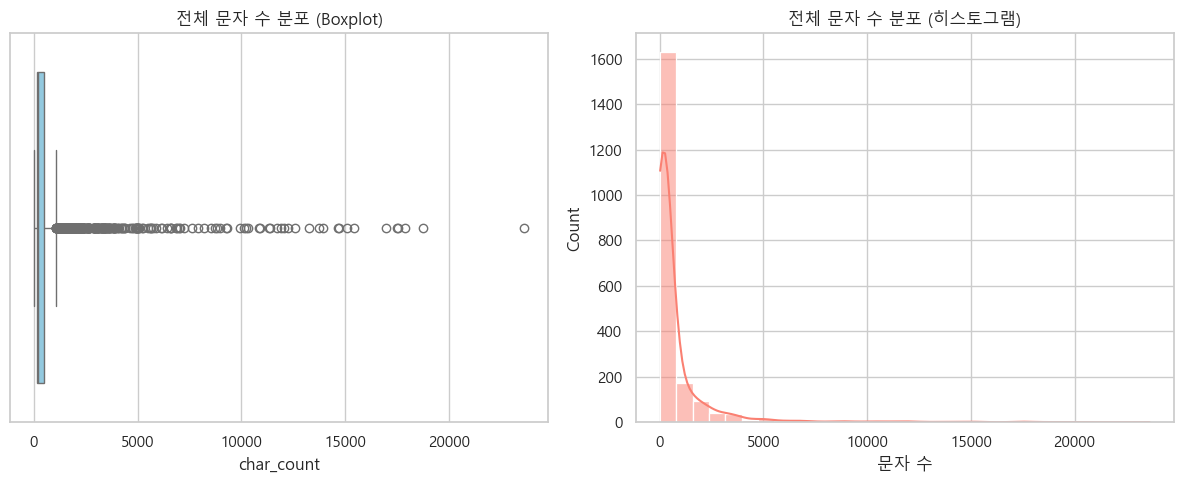

In [28]:
# 📦 3. 전체 문자 수 분포 (Boxplot + Histogram)
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=msg_lengths["char_count"], color="skyblue")
plt.title("전체 문자 수 분포 (Boxplot)")

plt.subplot(1, 2, 2)
sns.histplot(msg_lengths["char_count"], bins=30, kde=True, color="salmon")
plt.title("전체 문자 수 분포 (히스토그램)")
plt.xlabel("문자 수")

plt.tight_layout()
plt.show()

In [ ]:
from konlpy.tag import Kkma

# 형태소 분석기 객체 생성
kkma = Kkma()


# 형태소 분석 함수 (불용어 제거 없이 주요 품사만 필터링)
def kkma_tokenizer(text):
    try:
        tokens = kkma.pos(text)
        # 명사(NNG, NNP), 동사(VV), 형용사(VA)만 추출
        keywords = [word for word, tag in tokens if tag in ["NNG", "NNP", "VV", "VA"]]
        keywords = [word for word in keywords if word != "OOO"]
        return keywords if keywords else ["없음"]
    except:
        return ["오류"]


# 적용
df["kkma_tokens"] = df["text"].apply(kkma_tokenizer)

# 결과 출력
# print(df)

In [ ]:
from collections import Counter
import pandas as pd

# 모든 키워드를 하나의 리스트로 합치기
all_keywords = sum(df["kkma_tokens"], [])  # 리스트 안 리스트를 평탄화

# 키워드 등장 빈도수 계산
keyword_counter = Counter(all_keywords)

# Counter → DataFrame 변환
keyword_freq_df = pd.DataFrame(
    keyword_counter.items(), columns=["keyword", "frequency"]
)

# 내림차순 정렬
keyword_freq_df = keyword_freq_df.sort_values(
    by="frequency", ascending=False
).reset_index(drop=True)

# 출력
# print(keyword_freq_df)
# 상위 700개 키워드만 추출
top_700_keywords = keyword_freq_df.head(700)

# 결과 확인
print(top_700_keywords)

In [ ]:
# top_700_keywords를 CSV 파일로 저장
top_700_keywords.to_csv("phishing_top_700_keywords.csv", index=False, encoding="utf-8-sig")